***PCA,RFE VE LOGIT***

In [15]:
import numpy as np
import pandas as pd

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [17]:
import statsmodels.formula.api as smf

In [18]:
df = pd.read_excel("/Users/mehmetbagdinli/Desktop/data_wvs/data_wvs.xlsx", sheet_name=0)
df = df.set_index(df.columns[0])

In [19]:
df.head

<bound method NDFrame.head of         y_conf_union  x_r_imp_relg  x_r_imp_god  x_r_att_srv  x_r_freq_pray  \
ind_id                                                                        
1                4.0           1.0         10.0          4.0            1.0   
2                4.0           1.0         10.0          1.0            1.0   
3                2.0           1.0         10.0          2.0            3.0   
4                4.0           1.0         10.0          4.0            1.0   
5                2.0           1.0         10.0          4.0            1.0   
...              ...           ...          ...          ...            ...   
4016             3.0           1.0          5.0          2.0            3.0   
4017             3.0           1.0         10.0          2.0            2.0   
4018             2.0           1.0          6.0          2.0            2.0   
4019             3.0           1.0         10.0          3.0            4.0   
4020             3.0  

In [20]:
df["x_r_imp_relg"]   = 5  - df["x_r_imp_relg"]
df["x_r_att_srv"]    = 8  - df["x_r_att_srv"]
df["x_r_freq_pray"]  = 9  - df["x_r_freq_pray"]
df["x_r_self_rel"]   = 4  - df["x_r_self_rel"]
df["x_e_fin_sat"] = 11 - df["x_e_fin_sat"]
df["x_e_no_food"] = 5 - df["x_e_no_food"]
df["x_e_no_med"]  = 5 - df["x_e_no_med"]
df["x_e_no_cash"] = 5 - df["x_e_no_cash"]
df["female"] = (df["dum_female"] == 2).astype(int)


In [21]:
df["x_edu_isced_adj"] = df["x_edu_isced"]
df.loc[(df["dum_year"] == 2018) & (df["x_edu_isced"] == 21), "x_edu_isced_adj"] = 4
df.loc[(df["dum_year"] == 2018) & (df["x_edu_isced"] == 22), "x_edu_isced_adj"] = 4
df["edu_z"] = (df.groupby("dum_year")["x_edu_isced_adj"].transform(lambda x: (x - x.mean()) / x.std()))

In [22]:
df["x_e_job_worry"] = 5 - df["x_e_job_worry"]

In [23]:

df_clean = df.copy()
df_clean.replace({-1: np.nan, -2: np.nan, -3: np.nan}, inplace=True)


df_clean["pro_union"] = (df_clean["y_conf_union"] >= 2).astype(int)


R_items = ["x_r_imp_relg", "x_r_imp_god", "x_r_att_srv", "x_r_freq_pray","x_r_self_rel"]

E_items = ["x_e_fin_sat", "x_e_job_worry","x_e_no_food","x_e_no_med","x_e_no_cash"]


df_pca = df_clean[R_items + E_items].dropna().copy()



In [24]:

scaler_R = StandardScaler()
R_scaled = scaler_R.fit_transform(df_pca[R_items])

pca_R = PCA()
pca_R.fit(R_scaled)


scaler_E = StandardScaler()
E_scaled = scaler_E.fit_transform(df_pca[E_items])

pca_E = PCA()
pca_E.fit(E_scaled)



PCA()

In [25]:

df_clean["R_pca1"] = np.nan
df_clean["E_pca1"] = np.nan

df_clean.loc[df_pca.index, "R_pca1"] = pca_R.transform(R_scaled)[:, 0]
df_clean.loc[df_pca.index, "E_pca1"] = pca_E.transform(E_scaled)[:, 0]

df_clean["R_pca1_z"] = (df_clean["R_pca1"] - df_clean["R_pca1"].mean()) / df_clean["R_pca1"].std()
df_clean["E_pca1_z"] = (df_clean["E_pca1"] - df_clean["E_pca1"].mean()) / df_clean["E_pca1"].std()


df_clean["RE_pca"] = df_clean["R_pca1_z"] * df_clean["E_pca1_z"]



In [27]:
from sklearn.preprocessing import StandardScaler

z_map = {"x_age": "age_z","x_inc_scale": "inc_z", "x_edu_isced": "edu_z","x_class_subj": "class_z"}
scaler = StandardScaler()


df_clean[list(z_map.values())] = scaler.fit_transform(df_clean[list(z_map.keys())])

In [28]:
rfe_vars = ["R_pca1_z", "E_pca1_z", "RE_pca","age_z", "inc_z", "edu_z", "class_z","dum_akp"]
forced_vars = ["female"]
fe_vars = ["reg_nuts1", "dum_year"]

In [29]:
df_rfe = df_clean[["pro_union"] + rfe_vars + forced_vars + fe_vars].dropna().copy()


In [30]:
X_rfe = df_rfe[rfe_vars]
y_rfe = df_rfe["pro_union"]


In [31]:
scaler = StandardScaler()
X_rfe_scaled = scaler.fit_transform(X_rfe)


logit_base = LogisticRegression(solver="liblinear",penalty="l2",max_iter=2000)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rfecv = RFECV(estimator=logit_base,step=1,cv=cv,scoring="roc_auc",min_features_to_select=3)
rfecv.fit(X_rfe_scaled, y_rfe)

selected_vars = np.array(rfe_vars)[rfecv.support_]

print("\n=== RFE SELECTED SUBSTANTIVE VARIABLES ===")
print(selected_vars)



=== RFE SELECTED SUBSTANTIVE VARIABLES ===
['R_pca1_z' 'E_pca1_z' 'RE_pca' 'age_z' 'inc_z' 'edu_z' 'class_z'
 'dum_akp']


In [32]:
df_clean.columns


Index(['y_conf_union', 'x_r_imp_relg', 'x_r_imp_god', 'x_r_att_srv',
       'x_r_freq_pray', 'x_r_self_rel', 'x_e_fin_sat', 'x_e_job_worry',
       'x_e_no_food', 'x_e_no_med', 'x_e_no_cash', 'dum_akp', 'x_pol_lr',
       'reg_nuts1', 'dum_year', 'x_age', 'dum_female', 'x_edu_isced',
       'x_class_subj', 'x_inc_scale', 'x_emp_stat', 'x_mar_stat', 'female',
       'x_edu_isced_adj', 'edu_z', 'pro_union', 'R_pca1', 'E_pca1', 'R_pca1_z',
       'E_pca1_z', 'RE_pca', 'age_z', 'inc_z', 'class_z'],
      dtype='object')

In [33]:
selected_str = " + ".join(selected_vars)

formula_final = f"""
pro_union ~
{selected_str}
+ female
+ C(reg_nuts1)
+ C(dum_year)
"""

print("FINAL MODEL FORMULA")
print(formula_final)

logit_final = smf.logit(formula=formula_final, data=df_rfe).fit(disp=False)

print("FINAL LOGIT REGRESSION OUTPUT")
print(logit_final.summary())


FINAL MODEL FORMULA

pro_union ~
R_pca1_z + E_pca1_z + RE_pca + age_z + inc_z + edu_z + class_z + dum_akp
+ female
+ C(reg_nuts1)
+ C(dum_year)

FINAL LOGIT REGRESSION OUTPUT
                           Logit Regression Results                           
Dep. Variable:              pro_union   No. Observations:                 2498
Model:                          Logit   Df Residuals:                     2476
Method:                           MLE   Df Model:                           21
Date:                Thu, 22 Jan 2026   Pseudo R-squ.:                 0.05115
Time:                        19:56:06   Log-Likelihood:                -797.68
converged:                       True   LL-Null:                       -840.68
Covariance Type:            nonrobust   LLR p-value:                 7.827e-10
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          

In [34]:
R_loadings = pd.DataFrame(pca_R.components_.T, index=R_items, columns=[f"PC{i+1}" for i in range(pca_R.n_components_)])

E_loadings = pd.DataFrame( pca_E.components_.T, index=E_items, columns=[f"PC{i+1}" for i in range(pca_E.n_components_)])

In [35]:
display("R PCA LOADINGS (PC1)",R_loadings[["PC1"]])
display("E PCA LOADINGS (PC1)",E_loadings[["PC1"]])

'R PCA LOADINGS (PC1)'

,PC1
x_r_imp_relg,0.465659
x_r_imp_god,0.454877
x_r_att_srv,0.420994
x_r_freq_pray,0.476515
x_r_self_rel,0.414664


'E PCA LOADINGS (PC1)'

,PC1
x_e_fin_sat,0.372402
x_e_job_worry,0.235289
x_e_no_food,0.513100
x_e_no_med,0.542885
x_e_no_cash,0.497956


In [36]:
display("R PCA EXPLAINED VARIANCE", pca_R.explained_variance_ratio_)
display( "E PCA EXPLAINED VARIANCE",pca_E.explained_variance_ratio_)


'R PCA EXPLAINED VARIANCE'

array([0.42162199, 0.18455845, 0.16718782, 0.12423039, 0.10240135])

'E PCA EXPLAINED VARIANCE'

array([0.44525427, 0.19366356, 0.17110406, 0.11574062, 0.0742375 ])

In [38]:
corr_R = df_clean.loc[df_pca.index, ["R_pca1_z"] + R_items].corr()
corr_E = df_clean.loc[df_pca.index, ["E_pca1_z"] + E_items].corr()

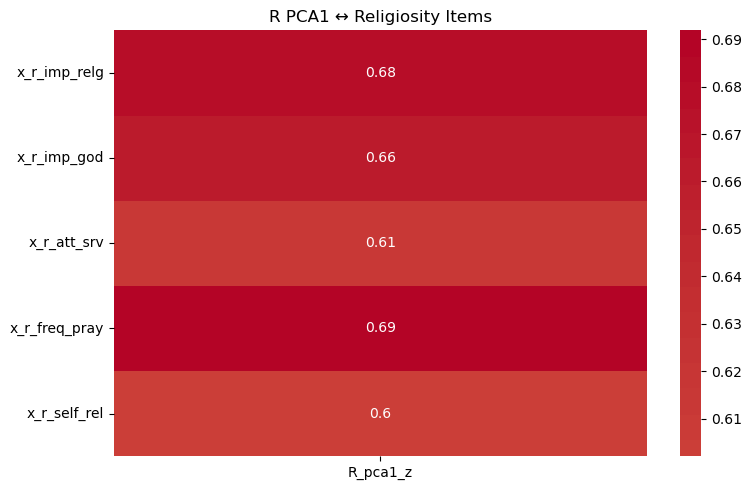

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.heatmap( corr_R.loc[R_items, ["R_pca1_z"]], annot=True, cmap="coolwarm", center=0 )
plt.title("R PCA1 ↔ Religiosity Items")
plt.tight_layout()
plt.show()


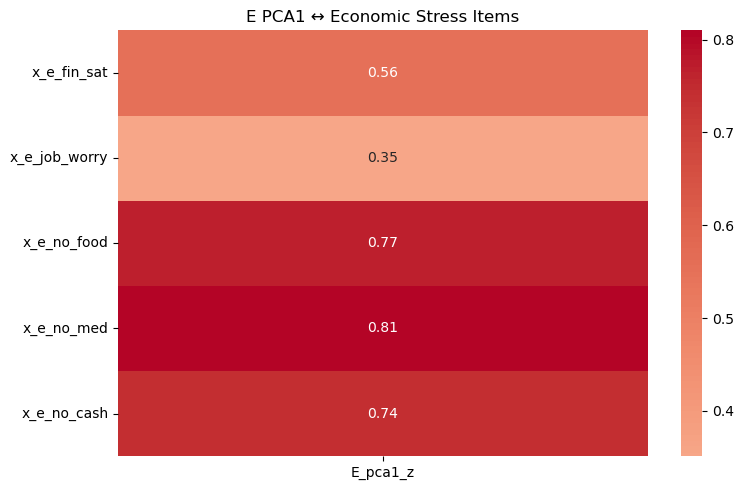

In [42]:
plt.figure(figsize=(8, 5))
sns.heatmap( corr_E.loc[E_items, ["E_pca1_z"]], annot=True, cmap="coolwarm", center=0)
plt.title("E PCA1 ↔ Economic Stress Items")
plt.tight_layout()
plt.show()

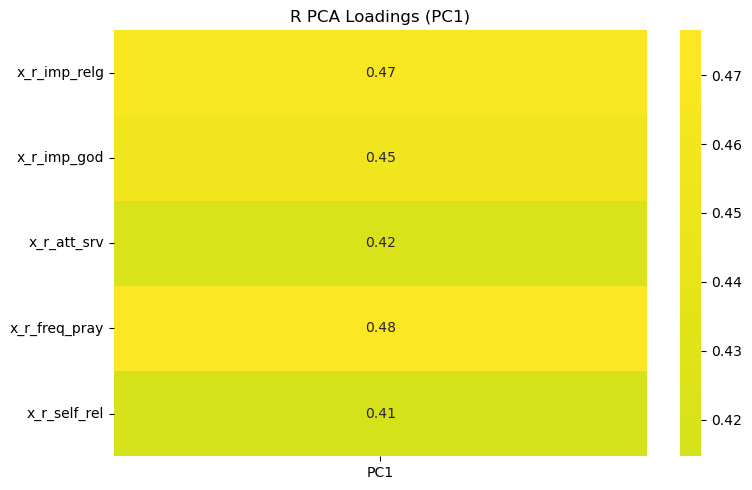

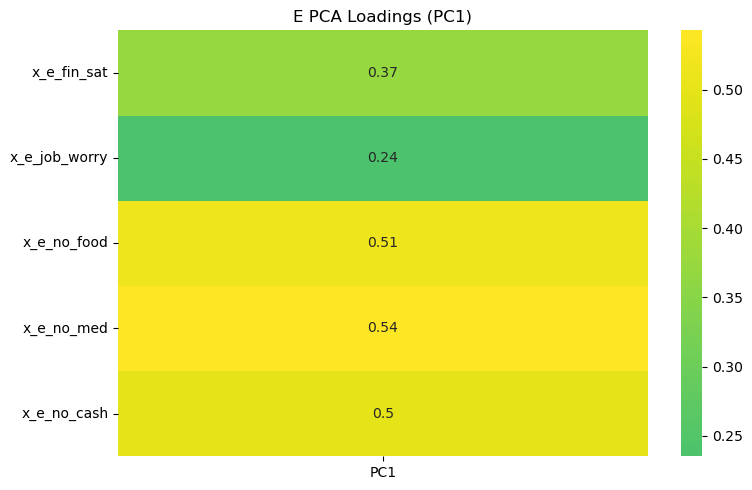

In [43]:
plt.figure(figsize=(8, 5))
sns.heatmap(R_loadings[["PC1"]],annot=True, cmap="viridis", center=0)
plt.title("R PCA Loadings (PC1)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.heatmap(E_loadings[["PC1"]],annot=True, cmap="viridis", center=0)
plt.title("E PCA Loadings (PC1)")
plt.tight_layout()
plt.show()


In [44]:
cluster_df = df_clean.loc[df_pca.index, ["R_pca1_z", "E_pca1_z"]].dropna().copy()

In [46]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5,random_state=42, n_init=50)

In [47]:
cluster_df["cluster"] = kmeans.fit_predict(cluster_df)

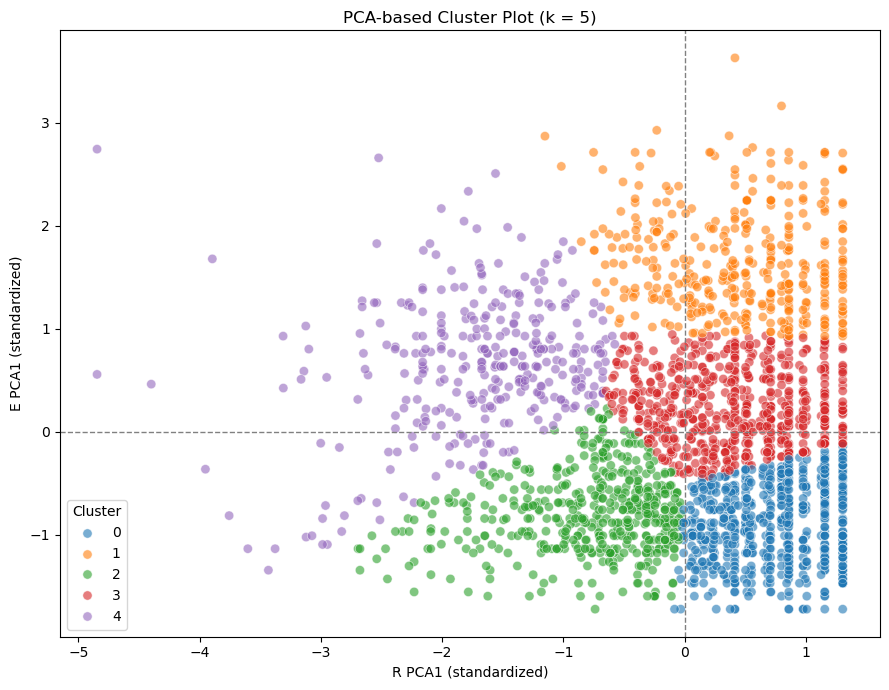

In [51]:
plt.figure(figsize=(9, 7))
sns.scatterplot(data=cluster_df, x="R_pca1_z", y="E_pca1_z", hue="cluster", palette="tab10",alpha=0.6, s=45)


plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.axvline(0, color="gray", linestyle="--", linewidth=1)

plt.xlabel("R PCA1 (standardized)")
plt.ylabel("E PCA1 (standardized)")
plt.title("PCA-based Cluster Plot (k = 5)")

plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


***DML***

In [52]:
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

In [53]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [57]:
def make_stacking_regressor(random_state=42):
    
    enet = Pipeline([
        ("scaler", StandardScaler()),
        ("enet", ElasticNetCV(
            l1_ratio=[0.1, 0.5, 0.9],
            alphas=np.logspace(-4, 2, 20),
            cv=5,
            max_iter=5000,
            random_state=random_state))])

    rf = RandomForestRegressor(
        n_estimators=600,
        min_samples_leaf=10,
        random_state=random_state,
        n_jobs=-1)

    gbr = GradientBoostingRegressor(random_state=random_state)

   
    final = RidgeCV(alphas=np.logspace(-4, 4, 25))

    stack = StackingRegressor(
        estimators=[("enet", enet), ("rf", rf), ("gbr", gbr)],
        final_estimator=final,
        passthrough=False,
        n_jobs=-1)
    return stack


In [58]:
def dml_plr_multitreat(
    df,
    y_col,
    d_cols,
    x_cols,
    K=5,
    random_state=42,
    learner_y=None,
    learner_d=None
):
    df_ = df[[y_col] + d_cols + x_cols].dropna().copy()

    Y = df_[y_col].astype(float).values
    D = df_[d_cols].astype(float).values
    X = df_[x_cols].astype(float).values  

    n, pD = D.shape

    if learner_y is None:
        learner_y = make_stacking_regressor(random_state)
    if learner_d is None:
        learner_d = make_stacking_regressor(random_state)

    kf = KFold(n_splits=K, shuffle=True, random_state=random_state)

    y_tilde = np.zeros(n)
    d_tilde = np.zeros((n, pD))

    for train_idx, test_idx in kf.split(X):
        X_tr, X_te = X[train_idx], X[test_idx]
        y_tr = Y[train_idx]
        D_tr = D[train_idx]

    # m(X): E[Y|X]
        m = make_stacking_regressor(random_state)
        m.fit(X_tr, y_tr)
        y_hat = m.predict(X_te)
        y_tilde[test_idx] = Y[test_idx] - y_hat

    # g_j(X): E[D_j|X] hepsine ayrı
        for j in range(pD):
            g = make_stacking_regressor(random_state + 100 + j)
            g.fit(X_tr, D_tr[:, j])
            d_hat = g.predict(X_te)
            d_tilde[test_idx, j] = D[test_idx, j] - d_hat

#THE SECOND ols with residuals
    X2 = sm.add_constant(d_tilde)
    ols = sm.OLS(y_tilde, X2).fit(cov_type="HC3")

    # sonuç tablosu
    params = ols.params[1:]   # const hariç
    ses    = ols.bse[1:]
    ci     = np.vstack([params - 1.96*ses, params + 1.96*ses]).T

    out = pd.DataFrame({
        "coef": params,
        "se": ses,
        "ci_low": ci[:,0],
        "ci_high": ci[:,1],
    }, index=d_cols)

    return out, ols


In [59]:
def build_X_with_FE(df, base_x_cols, fe_cols):
    X = df[base_x_cols + fe_cols].copy()
    X = pd.get_dummies(X, columns=fe_cols, drop_first=True)
    return X


In [60]:
y_col  = "pro_union"
d_cols = ["R_pca1_z", "E_pca1_z", "RE_pca"]

base_controls = ["x_age", "x_inc_scale", "x_edu_isced", "x_class_subj", "dum_female"]  # örnek
P_col = "dum_akp"
fe_cols = ["reg_nuts1", "dum_year"]

In [63]:
#AKPsiz DML
X_A = build_X_with_FE(df_clean, base_controls, fe_cols)
df_A = pd.concat([df_clean[[y_col] + d_cols], X_A], axis=1)
x_cols_A = list(X_A.columns)

In [65]:
#yukarda yazdığımız fonksiyonu runlıyoruz k=5
res_A, model_A = dml_plr_multitreat(df_A, y_col=y_col, d_cols=d_cols, x_cols=x_cols_A, K=5)
display("DML-A (FE dummies in X, P yok)", res_A)

'DML-A (FE dummies in X, P yok)'

,coef,se,ci_low,ci_high
R_pca1_z,-0.001249,0.006936,-0.014844,0.012346
E_pca1_z,0.006266,0.007150,-0.007748,0.020279
RE_pca,-0.007735,0.006097,-0.019685,0.004215


In [76]:
#akpli
X_B = build_X_with_FE(df_clean, base_controls + [P_col], fe_cols)
df_B = pd.concat([df_clean[[y_col] + d_cols], X_B], axis=1)
x_cols_B = list(X_B.columns)

res_B, model_B = dml_plr_multitreat(df_B, y_col=y_col, d_cols=d_cols, x_cols=x_cols_B, K=5)
display("DML-B (FE dummies in X, P VAR)", res_B)

'DML-B (FE dummies in X, P VAR)'

,coef,se,ci_low,ci_high
R_pca1_z,-0.003054,0.007052,-0.016875,0.010768
E_pca1_z,0.006464,0.007184,-0.007616,0.020545
RE_pca,-0.007560,0.006128,-0.019571,0.004451


In [68]:
#residualisation ve partialout için bunları tanımladım (kontrol et sonra)
def residualize_on_FE(df, var, fe_cols):
    f = var + " ~ " + " + ".join([f"C({c})" for c in fe_cols])
    m = smf.ols(f, data=df).fit()
    return m.resid

def partial_out_block(df, y_col, d_cols, fe_cols):
    out = df.copy()
    out[y_col + "_tilde"] = residualize_on_FE(out, y_col, fe_cols)
    for d in d_cols:
        out[d + "_tilde"] = residualize_on_FE(out, d, fe_cols)
    return out


In [70]:

df_po = partial_out_block(df_clean.dropna(subset=[y_col] + d_cols + fe_cols).copy(),
                          y_col=y_col, d_cols=d_cols, fe_cols=fe_cols)

y_tilde_col = y_col + "_tilde"
d_tilde_cols = [c + "_tilde" for c in d_cols]

In [74]:
# akpsiz partialout k hep 5 cvli
df_A2 = df_po[[y_tilde_col] + d_tilde_cols + base_controls].dropna().copy()
res_A2, model_A2 = dml_plr_multitreat(df_A2, y_col=y_tilde_col, d_cols=d_tilde_cols, x_cols=base_controls, K=5)
display("Partial-out + DML-A (P yok)\n", res_A2)

#akpli
df_B2 = df_po[[y_tilde_col] + d_tilde_cols + base_controls + [P_col]].dropna().copy()
res_B2, model_B2 = dml_plr_multitreat(df_B2, y_col=y_tilde_col, d_cols=d_tilde_cols, x_cols=base_controls + [P_col], K=5)
display("\nPartial-out + DML-B (P var)\n", res_B2)

'Partial-out + DML-A (P yok)\n'

,coef,se,ci_low,ci_high
R_pca1_z_tilde,0.000895,0.006785,-0.012404,0.014195
E_pca1_z_tilde,0.008603,0.007060,-0.005235,0.022441
RE_pca_tilde,-0.010170,0.006010,-0.021950,0.001611


'\nPartial-out + DML-B (P var)\n'

,coef,se,ci_low,ci_high
R_pca1_z_tilde,-0.001248,0.006896,-0.014765,0.012268
E_pca1_z_tilde,0.008392,0.007120,-0.005563,0.022348
RE_pca_tilde,-0.010222,0.006035,-0.022051,0.001607


In [77]:
report = pd.concat({
    "DML-A_FE-in-X": res_A,
    "DML-B_FE-in-X": res_B,
    "DML-A_PartialOut": res_A2.set_index(pd.Index(d_cols)),
    "DML-B_PartialOut": res_B2.set_index(pd.Index(d_cols)),
}, axis=1)

display("COMPARISON TABLE ", report)

'COMPARISON TABLE '

DML-A_FE-in-X                               DML-B_FE-in-X            \
                  coef        se    ci_low   ci_high          coef        se   
R_pca1_z     -0.001249  0.006936 -0.014844  0.012346     -0.003054  0.007052   
E_pca1_z      0.006266  0.007150 -0.007748  0.020279      0.006464  0.007184   
RE_pca       -0.007735  0.006097 -0.019685  0.004215     -0.007560  0.006128   

                             DML-A_PartialOut                                \
            ci_low   ci_high             coef        se    ci_low   ci_high   
R_pca1_z -0.016875  0.010768         0.000895  0.006785 -0.012404  0.014195   
E_pca1_z -0.007616  0.020545         0.008603  0.007060 -0.005235  0.022441   
RE_pca   -0.019571  0.004451        -0.010170  0.006010 -0.021950  0.001611   

         DML-B_PartialOut                                
                     coef        se    ci_low   ci_high  
R_pca1_z        -0.001248  0.006896 -0.014765  0.012268  
E_pca1_z         0.008392  0.007120 -0.005563  0.022348  
RE_pca          -0.010222  0.006035 -0.022051  0.001607

In [81]:
#direkt kısa halini buldum dlmli bloğu kullanmadan
df_clean["R_AKP"] = df_clean["R_pca1_z"] * df_clean["dum_akp"]
df_clean["E_AKP"] = df_clean["E_pca1_z"] * df_clean["dum_akp"]

vars_to_resid = ["pro_union","R_pca1_z", "E_pca1_z","RE_pca","R_AKP","E_AKP"]

df_po = df_clean.copy()

for v in vars_to_resid:
    f = v + " ~ C(reg_nuts1) + C(dum_year)"
    m = smf.ols(f, data=df_po).fit()
    df_po[v + "_tilde"] = m.resid

df_po.head(2)

,y_conf_union,x_r_imp_relg,x_r_imp_god,x_r_att_srv,x_r_freq_pray,x_r_self_rel,x_e_fin_sat,x_e_job_worry,x_e_no_food,x_e_no_med,...,inc_z,class_z,R_AKP,E_AKP,pro_union_tilde,R_pca1_z_tilde,E_pca1_z_tilde,RE_pca_tilde,R_AKP_tilde,E_AKP_tilde
ind_id,,,,,,,,,,,,,,,,,,,,,
1,4.0,4.0,10.0,4.0,8.0,3.0,6.0,NaN,4.0,4.0,...,0.841869,-1.190327,NaN,NaN,0.18581,NaN,NaN,NaN,NaN,NaN
2,4.0,4.0,10.0,7.0,8.0,3.0,5.0,4.0,1.0,1.0,...,-2.477937,-0.101559,1.303107,-0.07187,0.18581,0.689828,0.016789,-0.075146,0.883444,-0.045026


In [82]:
y_col = "pro_union_tilde"

d_cols_het = [ "R_pca1_z_tilde", "E_pca1_z_tilde","RE_pca_tilde","R_AKP_tilde","E_AKP_tilde"]

x_cols = base_controls + ["dum_akp"]  

res_het, _ = dml_plr_multitreat(df=df_po,y_col=y_col,d_cols=d_cols_het,x_cols=x_cols, K=5)

print(res_het)


                    coef        se    ci_low   ci_high
R_pca1_z_tilde  0.005106  0.008369 -0.011297  0.021509
E_pca1_z_tilde  0.024474  0.009553  0.005749  0.043199
RE_pca_tilde   -0.005658  0.006490 -0.018378  0.007062
R_AKP_tilde    -0.016858  0.013196 -0.042721  0.009006
E_AKP_tilde    -0.035739  0.014989 -0.065118 -0.006359


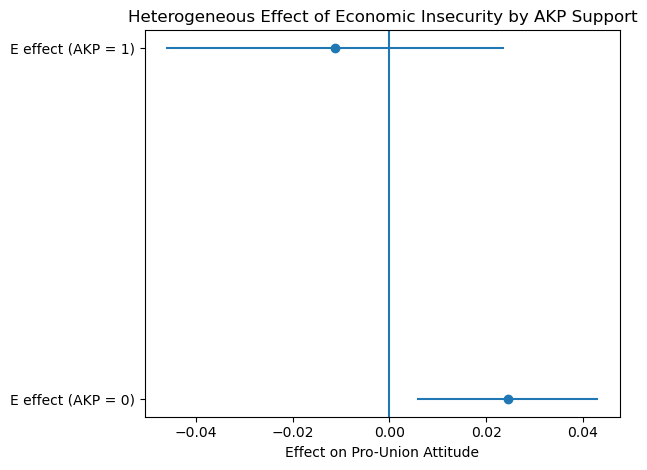

In [83]:
#akpnin etkisini negatif buldum ters yazmışım

beta_E = 0.024465      
se_E   = 0.009552

beta_E_AKP = -0.035700    
se_E_AKP   = 0.014986


beta_E_AKP1 = beta_E + beta_E_AKP
se_E_AKP1   = np.sqrt(se_E**2 + se_E_AKP**2)

effects = [beta_E, beta_E_AKP1]
ses = [se_E, se_E_AKP1]
labels = ["E effect (AKP = 0)", "E effect (AKP = 1)"]

y_pos = np.arange(len(effects))

plt.figure()
plt.errorbar(
    effects,
    y_pos,
    xerr=[1.96*np.array(ses), 1.96*np.array(ses)],
    fmt="o"
)
plt.axvline(0)
plt.yticks(y_pos, labels)
plt.xlabel("Effect on Pro-Union Attitude")
plt.title("Heterogeneous Effect of Economic Insecurity by AKP Support")
plt.tight_layout()
plt.show()



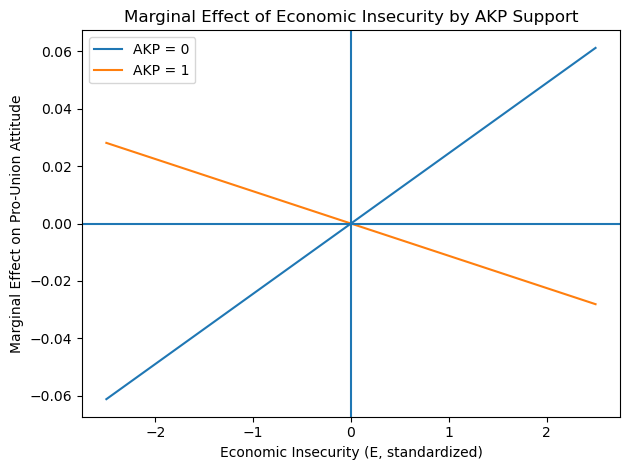

In [85]:
#yukardaki partially outtaki coefler ve sapmalrıyla
beta_E = 0.024465
beta_E_AKP = -0.035700
beta_E_AKP1 = beta_E + beta_E_AKP

E_grid = np.linspace(-2.5, 2.5, 100)

ME_AKP0 = beta_E * E_grid
ME_AKP1 = beta_E_AKP1 * E_grid

plt.figure()
plt.plot(E_grid, ME_AKP0, label="AKP = 0")
plt.plot(E_grid, ME_AKP1, label="AKP = 1")
plt.axhline(0)
plt.axvline(0)
plt.xlabel("Economic Insecurity (E, standardized)")
plt.ylabel("Marginal Effect on Pro-Union Attitude")
plt.title("Marginal Effect of Economic Insecurity by AKP Support")
plt.legend()
plt.tight_layout()
plt.show()


***Random Forest***

In [86]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance, PartialDependenceDisplay


In [87]:
#dmlden bulduğumuz önemli etkiler
features = [ "R_pca1_z_tilde", "E_pca1_z_tilde", "RE_pca_tilde", "dum_akp"]

target = "pro_union_tilde"

df_rf = df_po[[target] + features].dropna().copy()

X = df_rf[features]
y = df_rf[target]

In [88]:
rf = RandomForestRegressor(n_estimators=500, min_samples_leaf=20, max_features="sqrt", random_state=42,n_jobs=-1)

rf.fit(X, y)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=20,
                      n_estimators=500, n_jobs=-1, random_state=42)

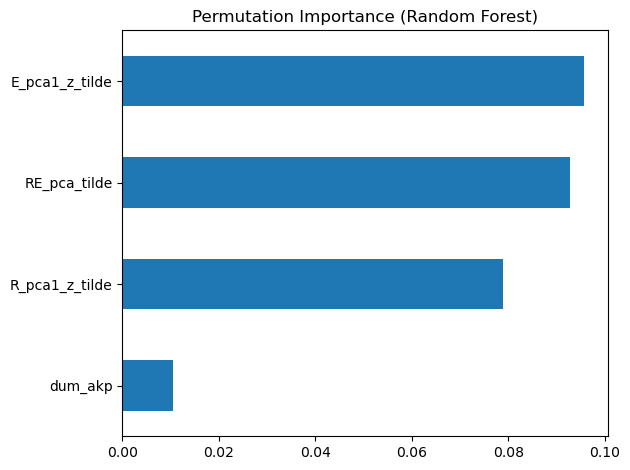

In [89]:
perm = permutation_importance(
    rf, X, y,
    n_repeats=15,
    random_state=42,
    n_jobs=-1
)

imp = pd.Series(perm.importances_mean, index=features).sort_values()

plt.figure()
imp.plot.barh()
plt.title("Permutation Importance (Random Forest)")
plt.tight_layout()
plt.show()

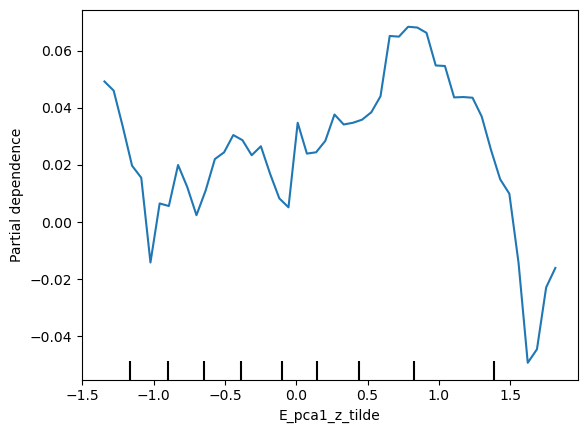

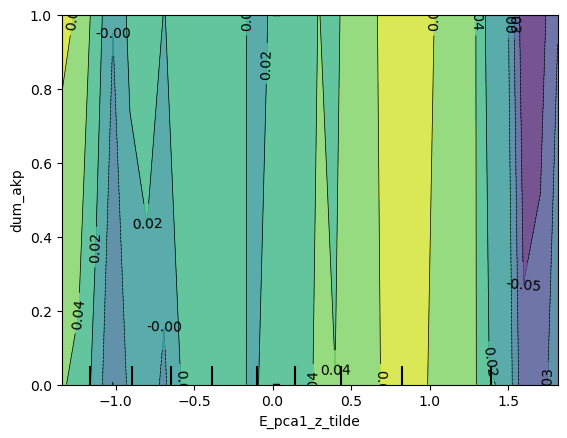

In [90]:
PartialDependenceDisplay.from_estimator(
    rf,
    X,
    features=["E_pca1_z_tilde"],
    grid_resolution=50
)

# Ekonomik insecurity ve AKP heterojenliği
PartialDependenceDisplay.from_estimator(
    rf,
    X,
    features=[("E_pca1_z_tilde", "dum_akp")],
    grid_resolution=30
)

plt.show()

In [92]:
from sklearn.inspection import permutation_importance, partial_dependence
print("Feature order:", list(enumerate(X.columns)))

pd_E = partial_dependence(rf,
    X,
    features=[1],        
    grid_resolution=25)

E_grid = pd_E["grid_values"][0]
E_pdp  = pd_E["average"][0]

pdp_E_table = pd.DataFrame({
    "E_pca1_z_tilde": E_grid,
    "PDP_predicted_y": E_pdp})

print("PDP TABLE (1D): E")
display(pdp_E_table.head(10))

Feature order: [(0, 'R_pca1_z_tilde'), (1, 'E_pca1_z_tilde'), (2, 'RE_pca_tilde'), (3, 'dum_akp')]
PDP TABLE (1D): E


,E_pca1_z_tilde,PDP_predicted_y
0,-1.344370,0.049179
1,-1.212709,0.033362
2,-1.081048,0.014686
3,-0.949387,0.006665
4,-0.817726,0.019581
5,-0.686065,0.004425
6,-0.554404,0.020443
7,-0.422742,0.029525
8,-0.291081,0.028409
9,-0.159420,0.013597


In [93]:
pd_2d = partial_dependence(
    rf,
    X,
    features=[(1, 3)],   # <-- (E index, AKP index)
    grid_resolution=25)

E_grid_2 = pd_2d["grid_values"][0]
AKP_grid = pd_2d["grid_values"][1]
avg_2d   = pd_2d["average"][0]

rows = []
for j, akp in enumerate(AKP_grid):
    for i, e in enumerate(E_grid_2):
        rows.append({
            "dum_akp": akp,
            "E_pca1_z_tilde": e,
            "PDP_predicted_y": avg_2d[i, j]})

pdp_2d_table = pd.DataFrame(rows)

print("PDP TABLE (2D): E × AKP (LONG)")
display(pdp_2d_table.head(10))

PDP TABLE (2D): E × AKP (LONG)


,dum_akp,E_pca1_z_tilde,PDP_predicted_y
0,0,-1.344370,0.037409
1,0,-1.212709,0.023340
2,0,-1.081048,0.006216
3,0,-0.949387,-0.002020
4,0,-0.817726,0.007673
5,0,-0.686065,-0.006348
6,0,-0.554404,0.014774
7,0,-0.422742,0.025403
8,0,-0.291081,0.027079
9,0,-0.159420,0.013498


In [94]:
pdp_2d_wide = pd.pivot_table(
    pdp_2d_table,
    index="E_pca1_z_tilde",
    columns="dum_akp",
    values="PDP_predicted_y").reset_index()

print("PDP TABLE (2D): E × AKP (WIDE)")
display(pdp_2d_wide.head(10))

PDP TABLE (2D): E × AKP (WIDE)


dum_akp,E_pca1_z_tilde,0,1
0,-1.344370,0.037409,0.060960
1,-1.212709,0.023340,0.043801
2,-1.081048,0.006216,0.024118
3,-0.949387,-0.002020,0.016361
4,-0.817726,0.007673,0.033037
5,-0.686065,-0.006348,0.016423
6,-0.554404,0.014774,0.026481
7,-0.422742,0.025403,0.034030
8,-0.291081,0.027079,0.029928
9,-0.159420,0.013498,0.013707
